### Multistep_MLP_with_additive_Decomposition

In [1]:
import datetime
import time
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.optimizers import SGD
from sklearn.preprocessing import MinMaxScaler
from keras import metrics


from statsmodels.compat.pandas import deprecate_kwarg
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
# additive decompose a contrived additive time series
from random import randrange
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose 

# the main library has a small set of functionality
from stldecompose import decompose, forecast
from stldecompose.forecast_funcs import (naive,
                                         drift, 
                                         mean, 
                                         seasonal_naive)
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
data = pd.read_csv('/Users/alket/Desktop/dati/new_data_backfill_forwfill.csv', index_col = 0, 
                   header=0, parse_dates=True)

In [3]:
agg_by_cell = data.groupby(by = ['cell_num'])
print(len(agg_by_cell), 'celle')

221 celle


In [18]:
count = 0
for i,k in agg_by_cell: 
    print(i, k)
    count += 1
    if count > 3: 
        break

486-1252                date  cell_num  nr_people  hours  minutes
0        2017-04-16  486-1252       36.0    0.0      0.0
221      2017-04-16  486-1252       36.0    0.0     15.0
442      2017-04-16  486-1252       34.0    0.0     30.0
663      2017-04-16  486-1252       33.0    0.0     45.0
884      2017-04-16  486-1252       32.0    1.0      0.0
...             ...       ...        ...    ...      ...
2608463  2017-08-16  486-1252       41.0   22.0     45.0
2608684  2017-08-16  486-1252       40.0   23.0      0.0
2608905  2017-08-16  486-1252       39.0   23.0     15.0
2609126  2017-08-16  486-1252       40.0   23.0     30.0
2609347  2017-08-16  486-1252       40.0   23.0     45.0

[11808 rows x 5 columns]
486-1253                date  cell_num  nr_people  hours  minutes
1        2017-04-16  486-1253       39.0    0.0      0.0
222      2017-04-16  486-1253       38.0    0.0     15.0
443      2017-04-16  486-1253       36.0    0.0     30.0
664      2017-04-16  486-1253       35.0    

In [19]:
serie_dati = agg_by_cell.get_group('486-1252')
serie_dati 

,date,cell_num,nr_people,hours,minutes
0,2017-04-16,486-1252,36.0,0.0,0.0
221,2017-04-16,486-1252,36.0,0.0,15.0
442,2017-04-16,486-1252,34.0,0.0,30.0
663,2017-04-16,486-1252,33.0,0.0,45.0
884,2017-04-16,486-1252,32.0,1.0,0.0
...,...,...,...,...,...
2608463,2017-08-16,486-1252,41.0,22.0,45.0
2608684,2017-08-16,486-1252,40.0,23.0,0.0
2608905,2017-08-16,486-1252,39.0,23.0,15.0
2609126,2017-08-16,486-1252,40.0,23.0,30.0


In [20]:
serie_dati = serie_dati.reset_index()

data4deco = serie_dati['nr_people']
type(data4deco)

pandas.core.series.Series

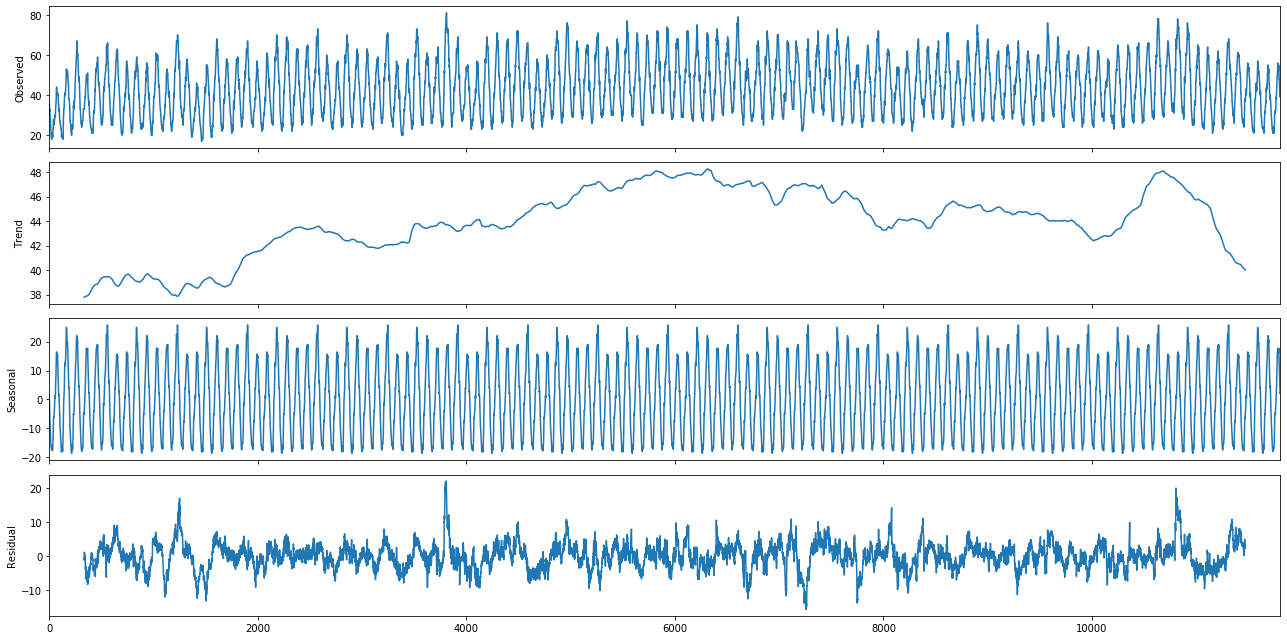

In [21]:
decompfreq = 672
result = seasonal_decompose(data4deco, freq=decompfreq, model='additive') 
with plt.rc_context():
     plt.rc("figure", figsize=(18,9))
     result.plot()
     plt.show()

### Prendi di dati per ciascun componente

In [22]:
data_trend = result.trend.values
data_residual = result.resid.values
data_seasonal = result.seasonal.values

In [23]:
print(data_trend)
start = decompfreq//2
print(start)

data_trend = data_trend[start:]
print('start ', data_trend)
data_trend = data_trend[:-start]
print('finish ', data_trend)
print(data_trend.shape)

data_residual = data_residual[start:]
print('start ', data_residual)
data_residual = data_residual[:-start]
print('finish ', data_residual)
print(data_residual.shape)

data_seasonal = data_seasonal[start:]
print('start ', data_seasonal)
data_seasonal = data_seasonal[:-start]
print('finish ', data_seasonal)
print(data_seasonal.shape)

[nan nan nan ... nan nan nan]
336
start  [37.78497024 37.79389881 37.80133929 ...         nan         nan
         nan]
finish  [37.78497024 37.79389881 37.80133929 ... 40.02901786 40.02306548
 40.01934524]
(11136,)
start  [-0.57111125 -1.10831363  1.23823749 ...         nan         nan
         nan]
finish  [-0.57111125 -1.10831363  1.23823749 ...  3.0181307   2.67136074
  2.44009323]
(11136,)
start  [-4.21385899 -3.68558518 -3.03957678 ...  2.28662245  2.10910144
  2.10805102]
finish  [-4.21385899 -3.68558518 -3.03957678 ... -6.04714856 -5.69442622
 -5.45943847]
(11136,)


In [24]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
         # find the end of this pattern
         end_ix = i + n_steps_in
         out_end_ix = end_ix + n_steps_out
         # check if we are beyond the sequence
         if out_end_ix > len(sequence):
             break
         # gather input and output parts of the pattern
         seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
         X.append(seq_x)
         y.append(seq_y)
    return np.array(X), np.array(y)

In [25]:
def get_forcast_per_component(series, st_in, st_out, train_test_size):
    
    # split into samples
    X, y = split_sequence(series, st_in, st_out)

    train_X, test_X = X[:train_test_size], X[train_test_size:]
    train_y, test_y = y[:train_test_size], y[train_test_size:]

    # define model
    model = Sequential()
    model.add(Dense(500, activation='relu', input_dim=st_in)) 
    model.add(Dense(st_out))

    model.compile(optimizer='adam', loss='mse' , metrics=[metrics.mae, 'accuracy'])

    # fit model
    model.fit(train_X, train_y, batch_size=64, epochs=50, verbose=2)
    
    # predict 
    predicted = []
    for i in range(len(test_X)):
        x_input = test_X[i].reshape(1, st_in)
        yhat = model.predict(x_input, verbose=0)
        
        #predicted.append(np.rint(yhat[0]))   
        predicted.append(np.around(yhat[0], decimals=1)) 
    predicted = np.array(predicted)
    return predicted

In [26]:
n_steps_in, n_steps_out = 80, 20
train_test_size = 9000

forcasted_trend = get_forcast_per_component(data_trend, n_steps_in, n_steps_out, train_test_size)
forcasted_residual = get_forcast_per_component(data_residual, n_steps_in, n_steps_out, train_test_size)
forcasted_season = get_forcast_per_component(data_seasonal, n_steps_in, n_steps_out, train_test_size)

Epoch 1/50
 - 0s - loss: 49.6643 - mean_absolute_error: 2.5051 - accuracy: 0.0887
Epoch 2/50
 - 0s - loss: 0.1229 - mean_absolute_error: 0.2694 - accuracy: 0.0547
Epoch 3/50
 - 0s - loss: 0.1239 - mean_absolute_error: 0.2711 - accuracy: 0.0594
Epoch 4/50
 - 0s - loss: 0.1233 - mean_absolute_error: 0.2702 - accuracy: 0.0581
Epoch 5/50
 - 0s - loss: 0.1234 - mean_absolute_error: 0.2708 - accuracy: 0.0524
Epoch 6/50
 - 0s - loss: 0.1248 - mean_absolute_error: 0.2732 - accuracy: 0.0613
Epoch 7/50
 - 0s - loss: 0.1215 - mean_absolute_error: 0.2690 - accuracy: 0.0439
Epoch 8/50
 - 0s - loss: 0.1191 - mean_absolute_error: 0.2660 - accuracy: 0.0620
Epoch 9/50
 - 0s - loss: 0.1198 - mean_absolute_error: 0.2674 - accuracy: 0.0482
Epoch 10/50
 - 0s - loss: 0.1204 - mean_absolute_error: 0.2681 - accuracy: 0.0453
Epoch 11/50
 - 0s - loss: 0.1177 - mean_absolute_error: 0.2657 - accuracy: 0.0494
Epoch 12/50
 - 0s - loss: 0.1168 - mean_absolute_error: 0.2642 - accuracy: 0.0313
Epoch 13/50
 - 0s - loss

 - 0s - loss: 11.6068 - mean_absolute_error: 2.2617 - accuracy: 0.5043
Epoch 2/50
 - 0s - loss: 2.9860 - mean_absolute_error: 1.2896 - accuracy: 0.6208
Epoch 3/50
 - 0s - loss: 2.5827 - mean_absolute_error: 1.2063 - accuracy: 0.6337
Epoch 4/50
 - 0s - loss: 2.2902 - mean_absolute_error: 1.1346 - accuracy: 0.6453
Epoch 5/50
 - 0s - loss: 2.1149 - mean_absolute_error: 1.0938 - accuracy: 0.6489
Epoch 6/50
 - 0s - loss: 1.9035 - mean_absolute_error: 1.0330 - accuracy: 0.6668
Epoch 7/50
 - 0s - loss: 1.7398 - mean_absolute_error: 0.9949 - accuracy: 0.6719
Epoch 8/50
 - 0s - loss: 1.6856 - mean_absolute_error: 0.9826 - accuracy: 0.6784
Epoch 9/50
 - 0s - loss: 1.5706 - mean_absolute_error: 0.9539 - accuracy: 0.6794
Epoch 10/50
 - 0s - loss: 1.4625 - mean_absolute_error: 0.9202 - accuracy: 0.6919
Epoch 11/50
 - 0s - loss: 1.3335 - mean_absolute_error: 0.8752 - accuracy: 0.6998
Epoch 12/50
 - 0s - loss: 1.2399 - mean_absolute_error: 0.8481 - accuracy: 0.7014
Epoch 13/50
 - 0s - loss: 1.1793 - 

In [27]:
final_prediction = forcasted_trend + forcasted_residual + forcasted_season
final_prediction[:2]

array([[39.9     , 39.6     , 39.3     , 38.399998, 37.200005, 35.9     ,
        35.300003, 33.399998, 33.100002, 32.5     , 32.4     , 31.9     ,
        31.9     , 31.7     , 31.899998, 31.900002, 31.7     , 31.400002,
        32.299995, 31.900002],
       [39.9     , 39.699997, 39.4     , 38.5     , 37.4     , 35.699997,
        35.      , 33.5     , 33.800003, 33.100002, 33.000004, 32.800003,
        32.5     , 32.3     , 32.299995, 31.800003, 31.5     , 31.2     ,
        31.2     , 31.800001]], dtype=float32)

In [28]:
X, y = split_sequence(serie_dati['nr_people'].values, n_steps_in, n_steps_out) 

X = X[start:]
#print('start ', X)
X = X[:-start]
#print('finish ', X)
#print(X.shape)

y = y[start:]
#print('start ', y)
y = y[:-start]
#print('finish ', y)
#print(y.shape)

train_X, train_y = X[:train_test_size], X[train_test_size:]
train_y, test_y = y[:train_test_size], y[train_test_size:]

In [29]:
print(final_prediction.shape)
expected = test_y
print(expected.shape)

(2037, 20)
(2037, 20)


In [30]:
difference = abs(expected - final_prediction)

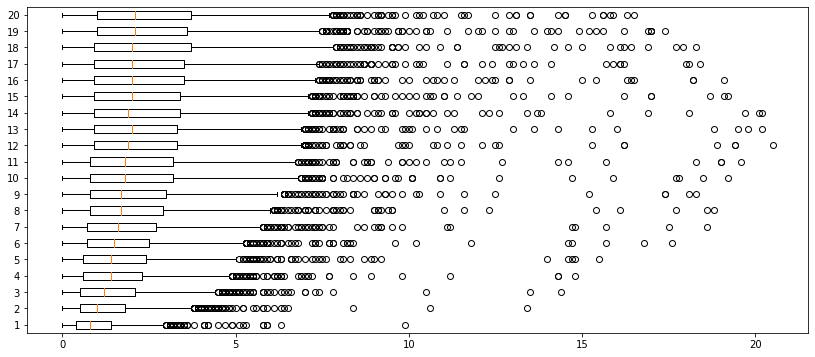

In [31]:
plt.figure(figsize = (14,6))
plt.boxplot(difference, vert= False);
plt.show()

Mean error 2.11613158276108


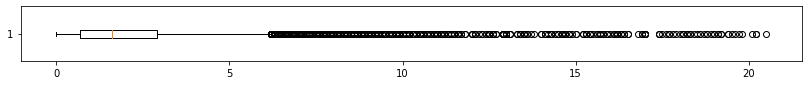

Valori cella


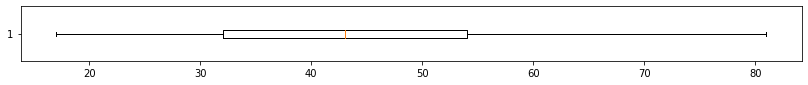

In [32]:
mean_error =  np.reshape(difference, difference.shape[0] * difference.shape[1])
print('Mean error', np.mean(mean_error))
plt.figure(figsize = (14,1))
plt.boxplot(mean_error, vert= False);
plt.show()
print('Valori cella')
plt.figure(figsize = (14, 1))
plt.boxplot(serie_dati['nr_people'].values, vert = False)
plt.show()